# SBA Loan Data Preprocessing

**Outline:**
1. Data Loading & Initial Exploration
2. Feature Selection
   - 2.1 Unique Value Analysis
   - 2.2 Correlation Analysis
   - 2.3 Missing Value Co-occurrence
   - 2.4 Imputing Missing CDC Columns
   - 2.5 Variance Inflation Factor (VIF)

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## 1. Data Loading & Initial Exploration

In [43]:
df = pd.read_excel('sba_loan.xlsx', sheet_name=0)
print(f'Shape: {df.shape}')
df.head()

/opt/miniconda3/envs/mse246/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Shape: (147423, 30)


,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,CDC_Name,CDC_Street,CDC_City,CDC_State,CDC_Zip,ThirdPartyLender_Name,ThirdPartyLender_City,ThirdPartyLender_State,ThirdPartyDollars,GrossApproval,ApprovalDate,ApprovalFiscalYear,DeliveryMethod,subpgmdesc,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,ProjectCounty,ProjectState,BusinessType,LoanStatus,ChargeOffDate,GrossChargeOffAmount
0,504,ROBERT G. FIELDS AND MARY D. F,55 & RICHLAND,KANSAS CITY,KS,66106,Avenue Area Incorporated,3324 Emerald Lane,Jefferson City,MO,65109.0,NaN,NaN,NaN,NaN,166000,1990-01-02,1990,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,NaN,12,NaN,NaN,WYANDOTTE,KS,INDIVIDUAL,PIF,NaT,0.0
1,504,CANDLELAMP COMPANY,3454 NIKI WAY,RIVERSIDE,CA,92507,CDC Small Business Finance Cor,2448 Historic Decatur,San Diego,CA,92106.0,NaN,NaN,NaN,NaN,117000,1990-01-02,1990,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,NaN,240,NaN,NaN,RIVERSIDE,CA,INDIVIDUAL,PIF,NaT,0.0
2,504,"NATIONAL COMPOSITES, INC.",2303 N. BENDIX DRIVE,SOUTH BEND,IN,46628,Business Development Corporati,218 W. Washington Street,South Bend,IN,46601.0,NaN,NaN,NaN,NaN,261000,1990-01-03,1990,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,NaN,120,NaN,NaN,ST JOSEPH,IN,CORPORATION,PIF,NaT,0.0
3,504,WENDY'S OF HARRISBURG,OUTLOT A. TR. 45N & SMALL ST,HARRISBURG,IL,62946,Small Business Growth Corporat,2401 West White Oaks Drive,Springfield,IL,62704.0,NaN,NaN,NaN,NaN,262000,1990-01-03,1990,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,NaN,240,NaN,NaN,SALINE,IL,CORPORATION,CHGOFF,2003-03-28,0.0
4,504,"RON SAUNORIS GARDEN CTR, INC.",13747 W. 159TH ST.,LOCKPORT,IL,60441,MISSNG/INACTV LENDER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462000,1990-01-03,1990,504,Sec. 504 - Loan Guarantees - Private Sector Fi...,NaN,240,NaN,NaN,WILL,IL,CORPORATION,CANCLD,NaT,0.0


In [44]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 147423 entries, 0 to 147422
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Program                 147423 non-null  int64         
 1   BorrName                147423 non-null  str           
 2   BorrStreet              147409 non-null  str           
 3   BorrCity                147422 non-null  str           
 4   BorrState               147421 non-null  str           
 5   BorrZip                 147423 non-null  int64         
 6   CDC_Name                147423 non-null  str           
 7   CDC_Street              147100 non-null  str           
 8   CDC_City                147100 non-null  str           
 9   CDC_State               147100 non-null  str           
 10  CDC_Zip                 147100 non-null  float64       
 11  ThirdPartyLender_Name   92806 non-null   str           
 12  ThirdPartyLender_City   92806 non-null   

Filter out cancelled and missing loan statuses — keep only **PIF** (Paid in Full) and **CHGOFF** (Charged Off) for default modeling.

In [45]:
# Remove rows where LoanStatus is 'CANCLD' or NaN
print(f'Before filtering: {len(df)} rows')
print(f'LoanStatus distribution:{df["LoanStatus"].value_counts(dropna=False)}')

df_1_1 = df[df['LoanStatus'].isin(['PIF', 'CHGOFF', 'EXEMPT'])]
df_1_1["LoanStatus"].value_counts(dropna=False)

Before filtering: 147423 rows
LoanStatus distribution:LoanStatus
EXEMPT    72836
PIF       45824
CANCLD    19780
CHGOFF     8982
NaN           1
Name: count, dtype: int64


LoanStatus
EXEMPT    72836
PIF       45824
CHGOFF     8982
Name: count, dtype: int64

## 2. Feature Selection

### 2.1 Unique Value Analysis

Identify columns with zero/low variation (candidates for removal) and high-cardinality columns (potential identifiers).

In [46]:
unique_counts = df_1_1.nunique().sort_values(ascending=False)
non_null_counts = df_1_1.count()  # count of non-NA values per column
unique_df = pd.DataFrame({
    'Non-NA Count': non_null_counts[unique_counts.index],
    'Unique Count': unique_counts,
    'Unique %': (unique_counts / len(df_1_1) * 100).round(2),
    'Dtype': df_1_1[unique_counts.index].dtypes
})
print(f'Total columns: {len(df_1_1.columns)}, Total rows: {len(df_1_1)}')
unique_df

Total columns: 30, Total rows: 127642


,Non-NA Count,Unique Count,Unique %,Dtype
BorrStreet,127630,124662,97.67,str
BorrName,127642,119550,93.66,str
ThirdPartyDollars,81453,27912,21.87,float64
BorrZip,127642,16393,12.84,int64
BorrCity,127641,14428,11.30,str
GrossChargeOffAmount,127642,7562,5.92,float64
ApprovalDate,127642,6110,4.79,datetime64[us]
ThirdPartyLender_Name,81516,4754,3.72,str
GrossApproval,127642,3184,2.49,int64
ThirdPartyLender_City,81516,2708,2.12,str


Drop `InitialInterestRate` and `Program` — they show no variation across rows.

In [47]:
df_2_1 = df_1_1.drop(columns=['InitialInterestRate','Program'])
df_2_1.columns

Index(['BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip',
       'CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'CDC_Zip',
       'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ThirdPartyDollars', 'GrossApproval',
       'ApprovalDate', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc',
       'TermInMonths', 'NaicsCode', 'NaicsDescription', 'ProjectCounty',
       'ProjectState', 'BusinessType', 'LoanStatus', 'ChargeOffDate',
       'GrossChargeOffAmount'],
      dtype='str')

Drop `BorrStreet`, `BorrName`, `NaicsDescription` as they are simply identifier

In [48]:
df_2_1 = df_2_1.drop(columns=['BorrStreet','BorrName','NaicsDescription'])

In [49]:
df_2_1.columns

Index(['BorrCity', 'BorrState', 'BorrZip', 'CDC_Name', 'CDC_Street',
       'CDC_City', 'CDC_State', 'CDC_Zip', 'ThirdPartyLender_Name',
       'ThirdPartyLender_City', 'ThirdPartyLender_State', 'ThirdPartyDollars',
       'GrossApproval', 'ApprovalDate', 'ApprovalFiscalYear', 'DeliveryMethod',
       'subpgmdesc', 'TermInMonths', 'NaicsCode', 'ProjectCounty',
       'ProjectState', 'BusinessType', 'LoanStatus', 'ChargeOffDate',
       'GrossChargeOffAmount'],
      dtype='str')

### 2.2 Correlation Analysis

#### 2.2.1 Numerical Variables — Pearson Correlation

In [50]:
df_2_2 = df_2_1.copy()

# Convert zip codes to string
df_2_2['BorrZip'] = df_2_2['BorrZip'].astype(str)
df_2_2['CDC_Zip'] = df_2_2['CDC_Zip'].fillna('000000').astype(int).astype(str)

df_2_2.columns

Index(['BorrCity', 'BorrState', 'BorrZip', 'CDC_Name', 'CDC_Street',
       'CDC_City', 'CDC_State', 'CDC_Zip', 'ThirdPartyLender_Name',
       'ThirdPartyLender_City', 'ThirdPartyLender_State', 'ThirdPartyDollars',
       'GrossApproval', 'ApprovalDate', 'ApprovalFiscalYear', 'DeliveryMethod',
       'subpgmdesc', 'TermInMonths', 'NaicsCode', 'ProjectCounty',
       'ProjectState', 'BusinessType', 'LoanStatus', 'ChargeOffDate',
       'GrossChargeOffAmount'],
      dtype='str')

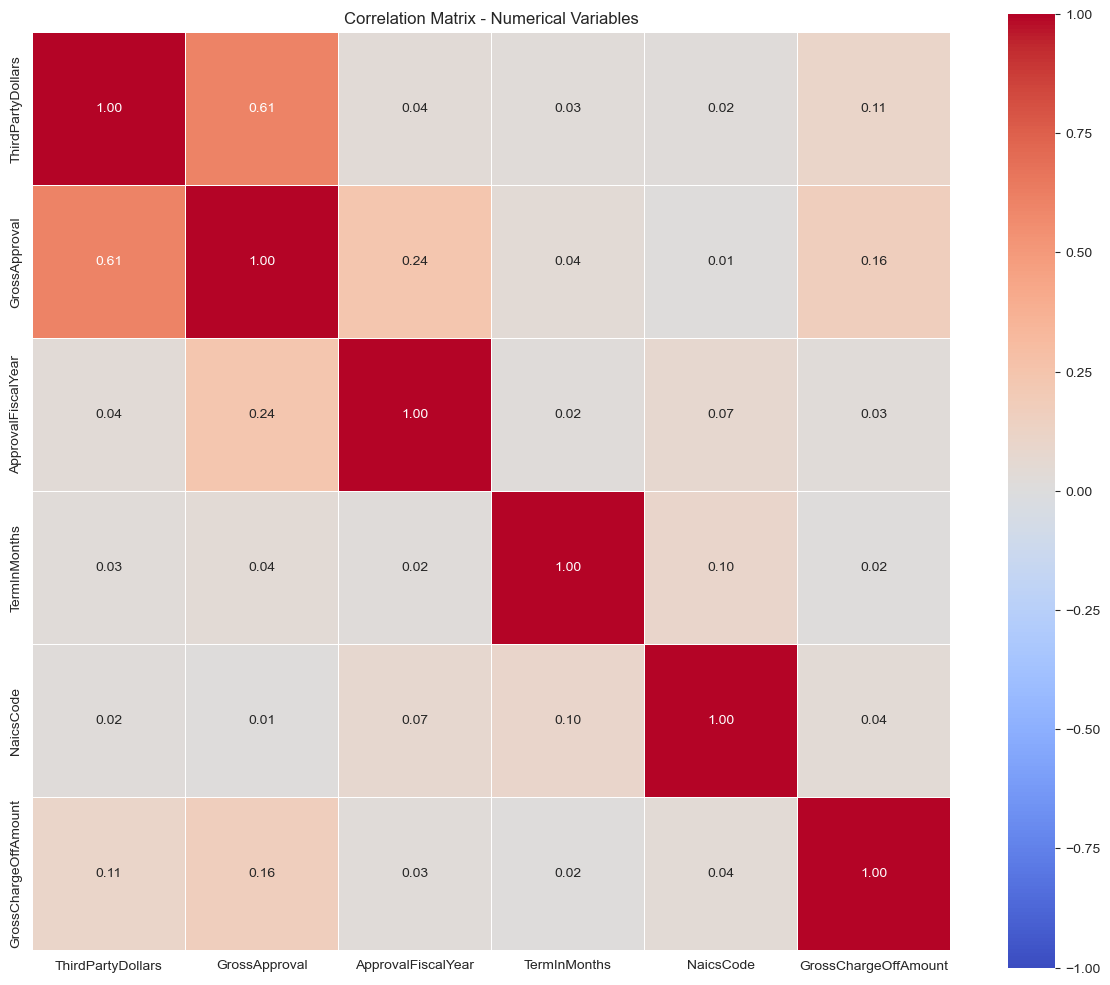

In [51]:
# Correlation matrix heatmap for numeric columns
numeric_df = df_2_2.select_dtypes(include=[np.number])
corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Correlation Matrix - Numerical Variables')
plt.tight_layout()
plt.show()

#### 2.2.2 Categorical Variables — Cramér's V

In [52]:
df_2_2.select_dtypes(include=['str']).columns

Index(['BorrCity', 'BorrState', 'BorrZip', 'CDC_Name', 'CDC_Street',
       'CDC_City', 'CDC_State', 'CDC_Zip', 'ThirdPartyLender_Name',
       'ThirdPartyLender_City', 'ThirdPartyLender_State', 'DeliveryMethod',
       'subpgmdesc', 'ProjectCounty', 'ProjectState', 'BusinessType',
       'LoanStatus'],
      dtype='str')

In [53]:
location_correlation_var = ['BorrCity', 'BorrState', 'BorrZip', 'CDC_Name', 'CDC_Street',
       'CDC_City', 'CDC_State', 'CDC_Zip','ThirdPartyLender_City', 'ThirdPartyLender_State','ThirdPartyLender_Name']

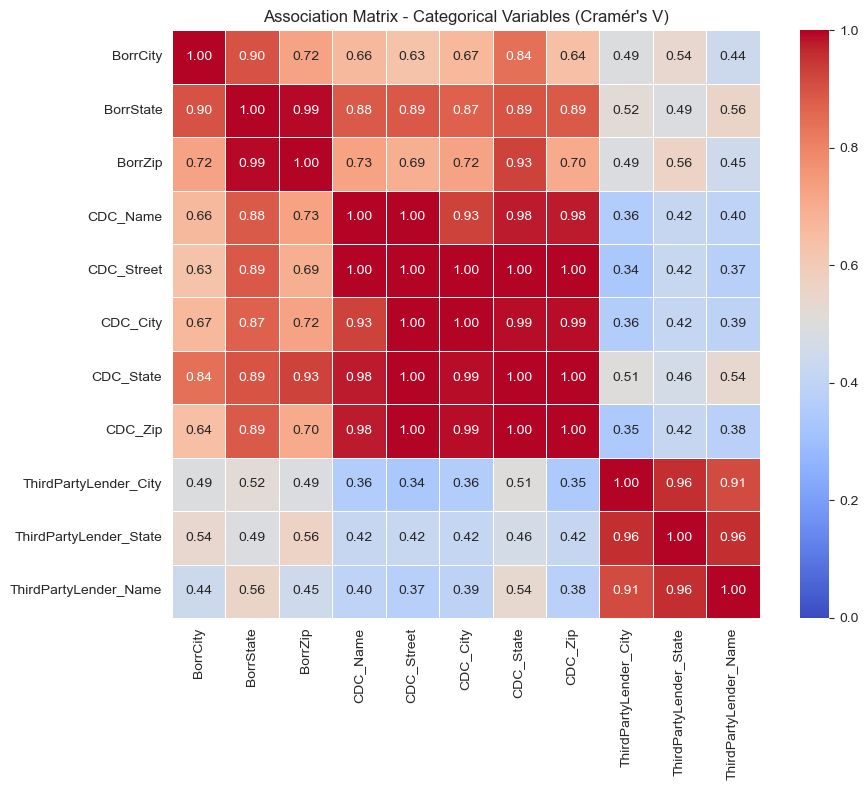

In [54]:
# Association matrix heatmap for categorical columns using Cramér's V
from scipy.stats import chi2_contingency

MAX_UNIQUE = 100
cat_cols = location_correlation_var

def cramers_v(x, y):
    """Compute Cramér's V statistic for two categorical Series."""
    contingency = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency)[0]
    n = len(x)
    min_dim = min(contingency.shape) - 1
    if min_dim == 0 or n == 0:
        return 0.0
    return np.sqrt(chi2 / (n * min_dim))

# Compute pairwise Cramér's V
n_cats = len(cat_cols)
cramer_matrix = np.ones((n_cats, n_cats))
for i in range(n_cats):
    for j in range(i + 1, n_cats):
        v = cramers_v(df[cat_cols[i]].fillna('MISSING'),
                      df[cat_cols[j]].fillna('MISSING'))
        cramer_matrix[i][j] = v
        cramer_matrix[j][i] = v

cramer_df = pd.DataFrame(cramer_matrix, index=cat_cols, columns=cat_cols)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cramer_df, annot=True, fmt='.2f', cmap='coolwarm', center=0.5,
            square=True, linewidths=0.5, ax=ax, vmin=0, vmax=1)
ax.set_title("Association Matrix - Categorical Variables (Cramér's V)")
plt.tight_layout()
plt.show()

#### 2.2.3 Drop Redundant columns

1. **Borrower location** (BorrCity, BorrState, BorrZip) — correlated 0.72–0.99
2. **CDC location** (CDC_Name, CDC_Street, CDC_City, CDC_State, CDC_Zip) — correlated 0.93–1.00
3. **Third Party Lender location** (ThirdPartyLender_City, ThirdPartyLender_State) — correlated 0.96

We want to keep zip codes, 

**Keep:**

- `BorrZip` — represents borrower geography
- `CDC_Zip` — represents CDC geography (0.70 with BorrZip, acceptable)
- `ThirdPartyLender_State` — represents lender geography, low correlation with zip columns (~0.42–0.56)

**Drop:**

- `BorrCity`, `BorrState` — redundant with `BorrZip`
- `CDC_Name`, `CDC_Street`, `CDC_City`, `CDC_State` — redundant with `CDC_Zip`
- `ThirdPartyLender_City` — redundant with `ThirdPartyLender_State`



In [55]:
columns_to_drop = [
    'BorrCity', 'BorrState',  # Redundant with BorrZip
    'CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State',  # Redundant with CDC_Zip
    'ThirdPartyLender_Name'  # Redundant with ThirdPartyLender_State
]

df_2_2_3 = df_2_2.drop(columns=columns_to_drop)


In [56]:
df_2_2_3.columns

Index(['BorrZip', 'CDC_Zip', 'ThirdPartyLender_City', 'ThirdPartyLender_State',
       'ThirdPartyDollars', 'GrossApproval', 'ApprovalDate',
       'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths',
       'NaicsCode', 'ProjectCounty', 'ProjectState', 'BusinessType',
       'LoanStatus', 'ChargeOffDate', 'GrossChargeOffAmount'],
      dtype='str')

## 3 Missing Value Co-occurrence

Check whether missing values in ThirdParty and CDC columns tend to occur together.

In [57]:
df_2_3 = df_2_2_3.copy()

In [58]:
# Missing values per column
missing = df_2_3.isnull().sum()
missing_pct = (missing / len(df_2_3) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)
missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Missing %
ChargeOffDate,118660,92.96
ThirdPartyDollars,46189,36.19
ThirdPartyLender_City,46126,36.14
ThirdPartyLender_State,45784,35.87
NaicsCode,17057,13.36
ProjectCounty,92,0.07
BusinessType,76,0.06
ProjectState,3,0.00


### 3.1 ThirdPartyLender

In [59]:
# Check if missing values co-occur across ThirdParty and CDC columns
third_party_cols = ['ThirdPartyLender_City',
                    'ThirdPartyLender_State', 'ThirdPartyDollars']

cols_to_check = third_party_cols 
missing_pattern = df_2_3[cols_to_check].isnull()

# Show co-occurrence: how many rows have all columns missing together
print('Missing value counts per column:')
print(missing_pattern.sum())
print(f'\nRows where ALL ThirdParty cols are missing: {missing_pattern[third_party_cols].all(axis=1).sum()}')
print(f'Rows where ANY ThirdParty col is missing:  {missing_pattern[third_party_cols].any(axis=1).sum()}')


Missing value counts per column:
ThirdPartyLender_City     46126
ThirdPartyLender_State    45784
ThirdPartyDollars         46189
dtype: int64

Rows where ALL ThirdParty cols are missing: 45784
Rows where ANY ThirdParty col is missing:  46524


In [60]:
# Create binary flag and fill missing ThirdParty values
df_2_3['HasThirdParty'] = df_2_3['ThirdPartyDollars'].notna().astype(int)
df_2_3['ThirdPartyDollars'] = df_2_3['ThirdPartyDollars'].fillna(0)
df_2_3['ThirdPartyLender_City'] = df_2_3['ThirdPartyLender_City'].fillna('UNKNOWN')
df_2_3['ThirdPartyLender_State'] = df_2_3['ThirdPartyLender_State'].fillna('UNKNOWN')


### 3.2 NaicsCode

NaicsD-Level information is too granular to capture any substanstial impact.

In [62]:
# Extract 2-digit NAICS sector code, fill missing with 'UNKNOWN'
df_2_3['NaicsSector'] = df_2_3['NaicsCode'].apply(lambda x: str(int(x))[:2] if pd.notna(x) else 'UNKNOWN')
df_3_2 = df_2_3.drop(columns=['NaicsCode'])

print(f'NaicsSector unique values: {df_3_2["NaicsSector"].nunique()}')
print(f'NaicsSector missing: {df_3_2["NaicsSector"].isnull().sum()}')
print(f'Distribution: {df_3_2["NaicsSector"].value_counts()}')

NaicsSector unique values: 26
NaicsSector missing: 0
Distribution: NaicsSector
UNKNOWN    17057
62         15319
72         14767
44         11870
54         10398
81          9813
33          8722
42          8511
23          7050
32          4407
45          2834
71          2799
56          2533
31          2196
53          2123
52          1805
48          1796
61          1194
51           994
11           769
49           337
21           129
99            88
22            77
55            41
92            13
Name: count, dtype: int64


In [63]:
missing = df_3_2.isnull().sum()
missing

BorrZip                        0
CDC_Zip                        0
ThirdPartyLender_City          0
ThirdPartyLender_State         0
ThirdPartyDollars              0
GrossApproval                  0
ApprovalDate                   0
ApprovalFiscalYear             0
DeliveryMethod                 0
subpgmdesc                     0
TermInMonths                   0
ProjectCounty                 92
ProjectState                   3
BusinessType                  76
LoanStatus                     0
ChargeOffDate             118660
GrossChargeOffAmount           0
HasThirdParty                  0
NaicsSector                    0
dtype: int64

### 3.3 Drop rows with missing values

Drop rows with missing `ProjectCounty`, `ProjectState`, or `BusinessType` 

These columns have very few missing values (92, 3, and 76 respectively), so dropping loses <0.1% of data.

In [64]:
cols_to_check = ['ProjectCounty', 'ProjectState', 'BusinessType']
n_before = len(df_3_2)
print(f'Before: {n_before} rows')
print(f'Missing values:\n{df[cols_to_check].isnull().sum()}')

df_3_3 = df_3_2.dropna(subset=cols_to_check)

print(f'\nAfter: {len(df_3_3)} rows')
print(f'Rows dropped: {n_before - len(df_3_3)}')

Before: 127642 rows
Missing values:
ProjectCounty    100
ProjectState       3
BusinessType      80
dtype: int64

After: 127475 rows
Rows dropped: 167


In [65]:
df_3_3.isnull().sum()


BorrZip                        0
CDC_Zip                        0
ThirdPartyLender_City          0
ThirdPartyLender_State         0
ThirdPartyDollars              0
GrossApproval                  0
ApprovalDate                   0
ApprovalFiscalYear             0
DeliveryMethod                 0
subpgmdesc                     0
TermInMonths                   0
ProjectCounty                  0
ProjectState                   0
BusinessType                   0
LoanStatus                     0
ChargeOffDate             118510
GrossChargeOffAmount           0
HasThirdParty                  0
NaicsSector                    0
dtype: int64

## 4. Export to CSV

Ensure all data types are correct before exporting.

In [67]:
# Ensure correct data types
df_export = df_3_3.copy()

# Categorical columns → str
str_cols = ['BorrZip', 'CDC_Zip', 'ThirdPartyLender_City', 'ThirdPartyLender_State',
            'DeliveryMethod', 'subpgmdesc', 'ProjectCounty', 'ProjectState',
            'BusinessType', 'LoanStatus', 'NaicsSector']
for col in str_cols:
    df_export[col] = df_export[col].astype(str)

# Numeric columns → appropriate types
df_export['GrossApproval'] = df_export['GrossApproval'].astype(int)
df_export['ThirdPartyDollars'] = df_export['ThirdPartyDollars'].astype(int)
df_export['GrossChargeOffAmount'] = df_export['GrossChargeOffAmount'].astype(int)
df_export['ApprovalFiscalYear'] = df_export['ApprovalFiscalYear'].astype(int)
df_export['TermInMonths'] = df_export['TermInMonths'].astype(int)
df_export['HasThirdParty'] = df_export['HasThirdParty'].astype(int)

# Datetime columns stay as-is (ApprovalDate, ChargeOffDate)

print('Final data types:')
print(df_export.dtypes)
print(f'Shape: {df_export.shape}')

Final data types:
BorrZip                              str
CDC_Zip                              str
ThirdPartyLender_City                str
ThirdPartyLender_State               str
ThirdPartyDollars                  int64
GrossApproval                      int64
ApprovalDate              datetime64[us]
ApprovalFiscalYear                 int64
DeliveryMethod                       str
subpgmdesc                           str
TermInMonths                       int64
ProjectCounty                        str
ProjectState                         str
BusinessType                         str
LoanStatus                           str
ChargeOffDate             datetime64[us]
GrossChargeOffAmount               int64
HasThirdParty                      int64
NaicsSector                          str
dtype: object
Shape: (127475, 19)


In [68]:
df_export.to_csv('sba_loan_cleaned.csv', index=False)
print(f'Exported {len(df_export)} rows to sba_loan_cleaned.csv')

Exported 127475 rows to sba_loan_cleaned.csv
